 # Load the relevant packages

In [1]:
library("SingleCellExperiment")
library("scater")
library("Matrix")
library('scuttle')
library("pheatmap")

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

# Load the data: start with count matrix, then gene and cell annotation data.

In [2]:
gene_annotation <- read.csv("GSE126954_gene_annotation.csv")[,2:3]
cell_annotation <- read.csv("GSE126954_cell_annotation.csv")[,-1]

In [3]:
# Load the saved data matrix from the previous steps. 
load("data_matrix.RData")

Select one time bin.

In [4]:
cells_bin = cell_annotation[cell_annotation$raw.embryo.time.bin!="< 170",]
data_matrix = data_matrix[,as.numeric(unlist(rownames(cells_bin)))]

Create SingleCellExperiment objects

In [5]:
sce <- SingleCellExperiment(
  assays = list(counts = data_matrix),
  rowData = data.frame(gene_names = rownames(data_matrix)),
  colData = data.frame(cell_names = colnames(data_matrix))
)

# Cleaning & QC

Use this object to clean the dataset by removing genes that are not expressed in any cell

Do some quality control

In [6]:
sce_filtered <- addPerCellQC(sce)
sce_filtered <- addPerFeatureQC(sce_filtered)

In [7]:
#hist(sce_filtered$total, breaks = 100) #hist of counts per cell

In [8]:
unique_genes_per_cell <- colSums(counts(sce)>0)
#hist(unique_genes_per_cell,breaks=100) #hist of unique genes per cell

If needed, these histograms can be used to determine thresholds for further filtering. 

# Get the log-transformed normalized expression values

In [9]:
sce <- logNormCounts(sce,transform="log") 
sce_log <- sce@assays@data@listData$logcounts

In [10]:
sce@assays@data@listData$counts[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
       AAACCTGAGACAATAC-300.1.1 AAACCTGAGGGCTCTC-300.1.1
nduo-6                        5                       20
ndfl-4                        .                        .
nduo-1                        0                        7
atp-6                         7                       17
nduo-2                        3                        .
       AAACCTGAGTGCGTGA-300.1.1 AAACCTGAGTTGAGTA-300.1.1
nduo-6                       37                       26
ndfl-4                        .                        1
nduo-1                       16                       14
atp-6                        28                       52
nduo-2                        0                        5
       AAACCTGCAAGACGTG-300.1.1
nduo-6                        4
ndfl-4                        .
nduo-1                        2
atp-6                         7
nduo-2                        .

# Keep only the list of genes

In [11]:
# For plotting the heatmap, we only focus on the predefined list of genes of interest
genes_of_interest = as.matrix(read.delim("genes_of_interest.txt", head=FALSE))
genes_index = which(gene_annotation[,2] %in% genes_of_interest)
gene_names = gene_annotation[genes_index,2]
length(gene_names)
sce_log <- sce_log[gene_names,]

[1] 88

In [12]:
# To exclude the genes with low expression levels in all the cells, we do a fitering here 
# Filtering criteria: keep the genes that has at least one cell with log norm counts > 4
keep_genes <- apply(sce_log[gene_names,], 1, max) > 4 # A boolean varaible for the genes to keep
gene_names <- gene_names[keep_genes]
length(gene_names)
gene_names

[1] 71

[1] "ced-10"  "deb-1"   "cap-1"   "wsp-1"   "epi-1"   "dnc-1"   "jac-1"  
 [8] "rho-1"   "pat-4"   "arx-4"   "mec-12"  "mlc-4"   "pat-3"   "cdh-4"  
[15] "arx-6"   "mlc-3"   "wrm-1"   "dlc-1"   "cdh-3"   "pac-1"   "pat-2"  
[22] "ina-1"   "tbg-1"   "arx-3"   "mlc-5"   "cyk-4"   "pfn-3"   "nmy-1"  
[29] "spc-1"   "act-4"   "pfn-2"   "lam-2"   "mec-7"   "plc-1"   "mlc-2"  
[36] "mlc-1"   "tln-1"   "ctn-1"   "dnc-5"   "arx-1"   "dnc-6"   "anc-1"  
[43] "dhc-1"   "rps-10"  "let-502" "fhod-1"  "unc-94"  "nmy-2"   "apr-1"  
[50] "che-3"   "lmn-1"   "hmr-1"   "dys-1"   "vab-10"  "pfn-1"   "lev-11" 
[57] "hmp-2"   "unc-60"  "unc-70"  "arx-2"   "act-3"   "act-2"   "act-1"  
[64] "hmp-1"   "sma-1"   "atn-1"   "inft-2"  "fmi-1"   "dnc-3"   "dsh-2"  
[71] "cap-2"

# Cell Type Info

In [13]:
cell_type <- cell_annotation[cell_annotation$cell %in% dimnames(sce_log)[[2]],6] 

Unique values in the vector cell_type that is not NA. We do not want to take the type-unidentified (na) cells into the differential expression analysis.

In [14]:
unique_cell_types <- unique(cell_type)[!is.na(unique(cell_type))]
unique_cell_types
length(unique_cell_types)

[1] "Body_wall_muscle"               "Ciliated_amphid_neuron"        
 [3] "Pharyngeal_neuron"              "Hypodermis"                    
 [5] "Ciliated_non_amphid_neuron"     "Pharyngeal_muscle"             
 [7] "Seam_cell"                      "Intestine"                     
 [9] "GLR"                            "Germline"                      
[11] "Excretory_cell"                 "Pharyngeal_intestinal_valve"   
[13] "Pharyngeal_gland"               "Pharyngeal_marginal_cell"      
[15] "Z1_Z4"                          "ABarpaaa_lineage"              
[17] "Parent_of_exc_gland_AVK"        "Parent_of_hyp1V_and_ant_arc_V" 
[19] "Intestinal_and_rectal_muscle"   "G2_and_W_blasts"               
[21] "Parent_of_exc_duct_pore_DB_1_3" "Glia"                          
[23] "hmc_and_homolog"                "Excretory_duct_and_pore"       
[25] "hmc"                            "Coelomocyte"                   
[27] "hmc_homolog"                    "Rectal_gland"                  
[29] "Excretory_cell_parent"          "hyp1V_and_ant_arc_V"           
[31] "M_cell"                         "Rectal_cell"                   
[33] "Arcade_cell"                    "Excretory_gland"               
[35] "XXX"                            "T"

[1] 36

In [15]:
cell_indices <- list()
cell_indices[['Muscle']] <- dimnames(sce_log[,which(cell_type %in% c('Body_wall_muscle','Intestinal_and_rectal_muscle','Pharyngeal_muscle'))])[[2]]
cell_indices[['Neuron']] <- dimnames(sce_log[,which(cell_type %in% c('Ciliated_amphid_neuron','Ciliated_non_amphid_neuron','Pharyngeal_neuron'))])[[2]]
cell_indices[['Gland']] <- dimnames(sce_log[,which(cell_type %in% c('Pharyngeal_gland','Parent_of_exc_gland_AVK','Rectal_gland','Excretory_gland'))])[[2]]
cell_indices[['Hypodermis']] <- dimnames(sce_log[,which(cell_type == 'Hypodermis')])[[2]]

In [16]:
length(cell_indices[['Muscle']])
length(cell_indices[['Neuron']])
length(cell_indices[['Gland']])
length(cell_indices[['Hypodermis']])

[1] 20650

[1] 12029

[1] 1370

[1] 7746

# Heatmap for the 88 genes and 4 cell types for all time bins

In [17]:
matList <- list()
cellTypeList <- list()
for (i in 1:4){
  mat <- sce_log[gene_names,(cell_indices[[i]])] #input:logcounts
  matList[[i]] <- mat
  cellTypeList[[i]]<-rep(names(cell_indices)[[i]],ncol(mat))
}

In [18]:
#mat.whole <- do.call(cbind,matList)
#cellType <- do.call(c,cellTypeList)
#cellType <- data.frame(cellType)
#dim(mat.whole)[2] == nrow(cellType)
#colnames(cellType) <- "Cell type"
#mat.whole <- data.frame(as.matrix(mat.whole))
#rownames(cellType) <- colnames(mat.whole)

In [19]:
#options(repr.plot.width=12, repr.plot.height=12)
#pheatmap(mat.whole, annotation=cellType, cluster_cols=FALSE, show_colnames=FALSE)

# Heatmap for different timebins within each cell type

In [20]:
cell_ind_timebin <- list()
cell_ind_timebin[['170-210']] <- dimnames(sce_log[,which(dimnames(sce_log)[[2]] %in% cell_annotation[cell_annotation$raw.embryo.time.bin=="170-210",][,1])])[[2]]
cell_ind_timebin[['210-270']] <- dimnames(sce_log[,which(dimnames(sce_log)[[2]] %in% cell_annotation[cell_annotation$raw.embryo.time.bin=="210-270",][,1])])[[2]]
cell_ind_timebin[['270-330']] <- dimnames(sce_log[,which(dimnames(sce_log)[[2]] %in% cell_annotation[cell_annotation$raw.embryo.time.bin=="270-330",][,1])])[[2]]
cell_ind_timebin[['330-390']] <- dimnames(sce_log[,which(dimnames(sce_log)[[2]] %in% cell_annotation[cell_annotation$raw.embryo.time.bin=="330-390",][,1])])[[2]]
cell_ind_timebin[['390-450']] <- dimnames(sce_log[,which(dimnames(sce_log)[[2]] %in% cell_annotation[cell_annotation$raw.embryo.time.bin=="390-450",][,1])])[[2]]
cell_ind_timebin[['450-510']] <- dimnames(sce_log[,which(dimnames(sce_log)[[2]] %in% cell_annotation[cell_annotation$raw.embryo.time.bin=="450-510",][,1])])[[2]]
cell_ind_timebin[['510-580']] <- dimnames(sce_log[,which(dimnames(sce_log)[[2]] %in% cell_annotation[cell_annotation$raw.embryo.time.bin=="510-580",][,1])])[[2]]
cell_ind_timebin[['580-650']] <- dimnames(sce_log[,which(dimnames(sce_log)[[2]] %in% cell_annotation[cell_annotation$raw.embryo.time.bin=="580-650",][,1])])[[2]]
cell_ind_timebin[['> 650']] <- dimnames(sce_log[,which(dimnames(sce_log)[[2]] %in% cell_annotation[cell_annotation$raw.embryo.time.bin=="> 650",][,1])])[[2]]

In [21]:
length(cell_ind_timebin)

[1] 9

## Muscle cells

In [22]:
mus <- matList[[1]] 
matListMus <- list() # for heatmap
timebinListMus <- list() # for heatmap
for (i in 1:length(cell_ind_timebin)){
    mat <- mus[,which(dimnames(mus)[[2]] %in% cell_ind_timebin[[i]])]
    matListMus[[i]] <- mat
    timebinListMus[[i]]<-rep(names(cell_ind_timebin)[[i]],ncol(mat))
}

In [23]:
mat.whole.Mus <- do.call(cbind,matListMus)
timebinMus <- do.call(c,timebinListMus)
timebinMus <- data.frame(timebinMus)
dim(mat.whole.Mus)[2] == nrow(timebinMus)
colnames(timebinMus) <- "Time bin"
mat.whole.Mus <- data.frame(as.matrix(mat.whole.Mus))
rownames(timebinMus) <- colnames(mat.whole.Mus)

[1] TRUE

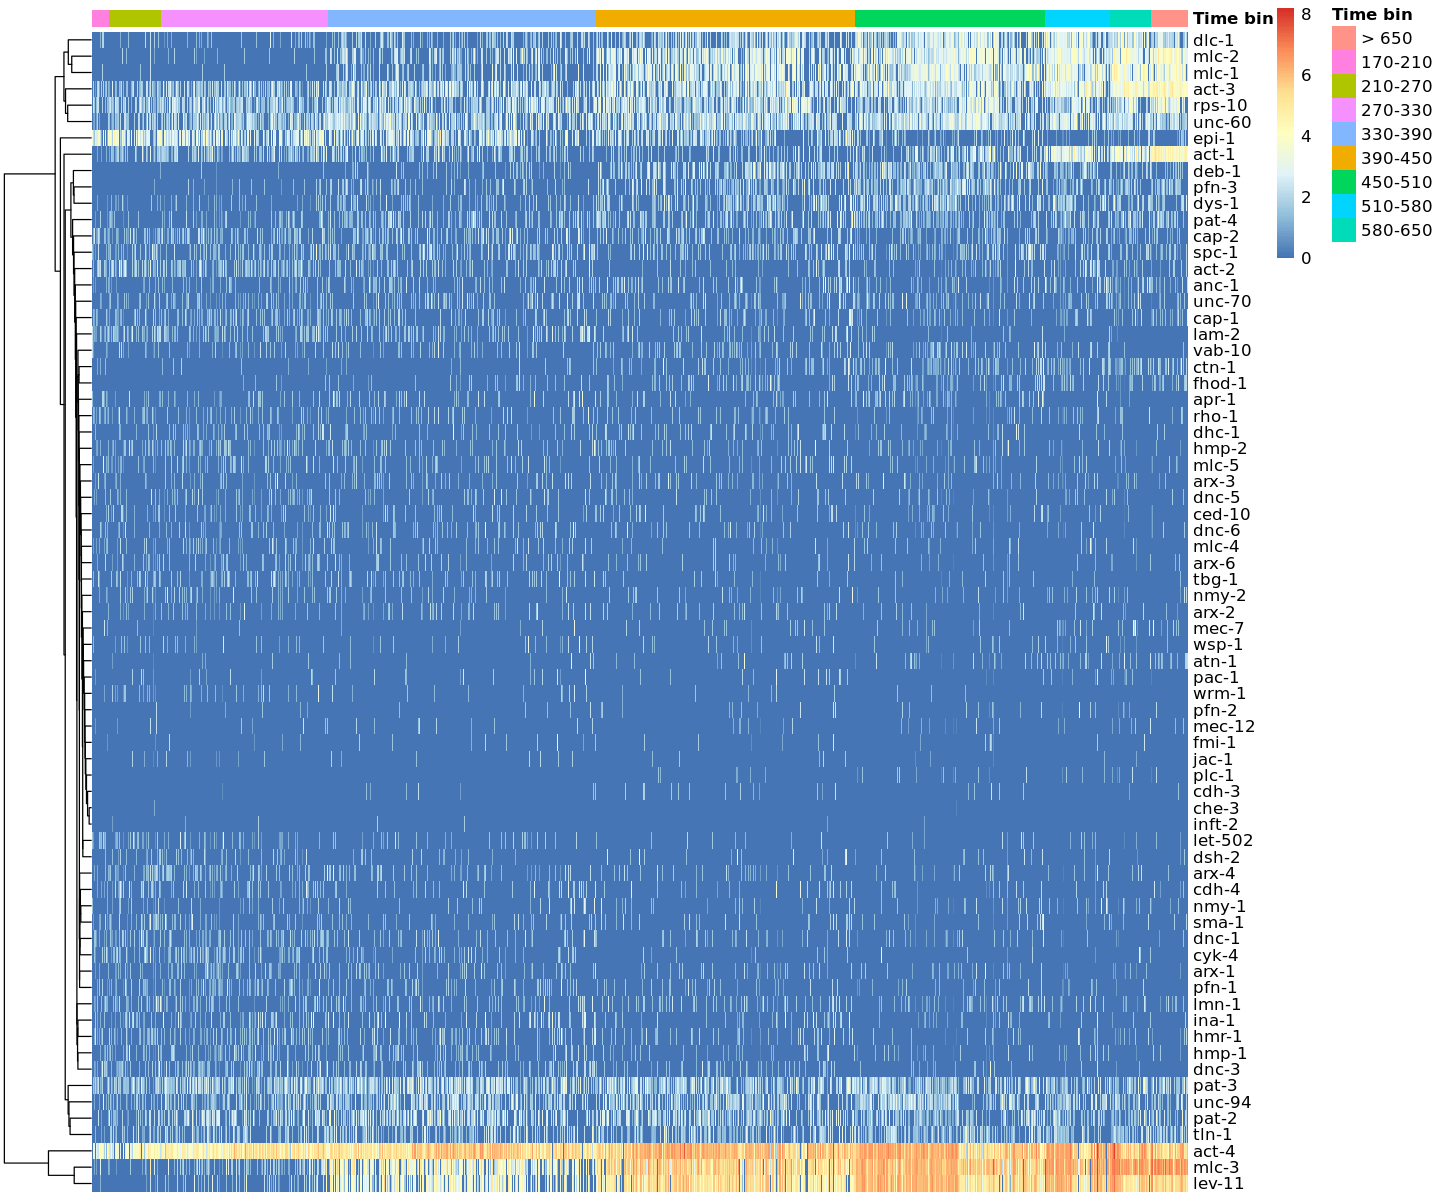

In [24]:
options(repr.plot.width=12, repr.plot.height=10)
pheatmap(mat.whole.Mus, annotation=timebinMus, cluster_cols=FALSE, show_colnames=FALSE)

# Violin plot

In [25]:
library(reshape2)
library(ggplot2)

No id variables; using all as measure variables



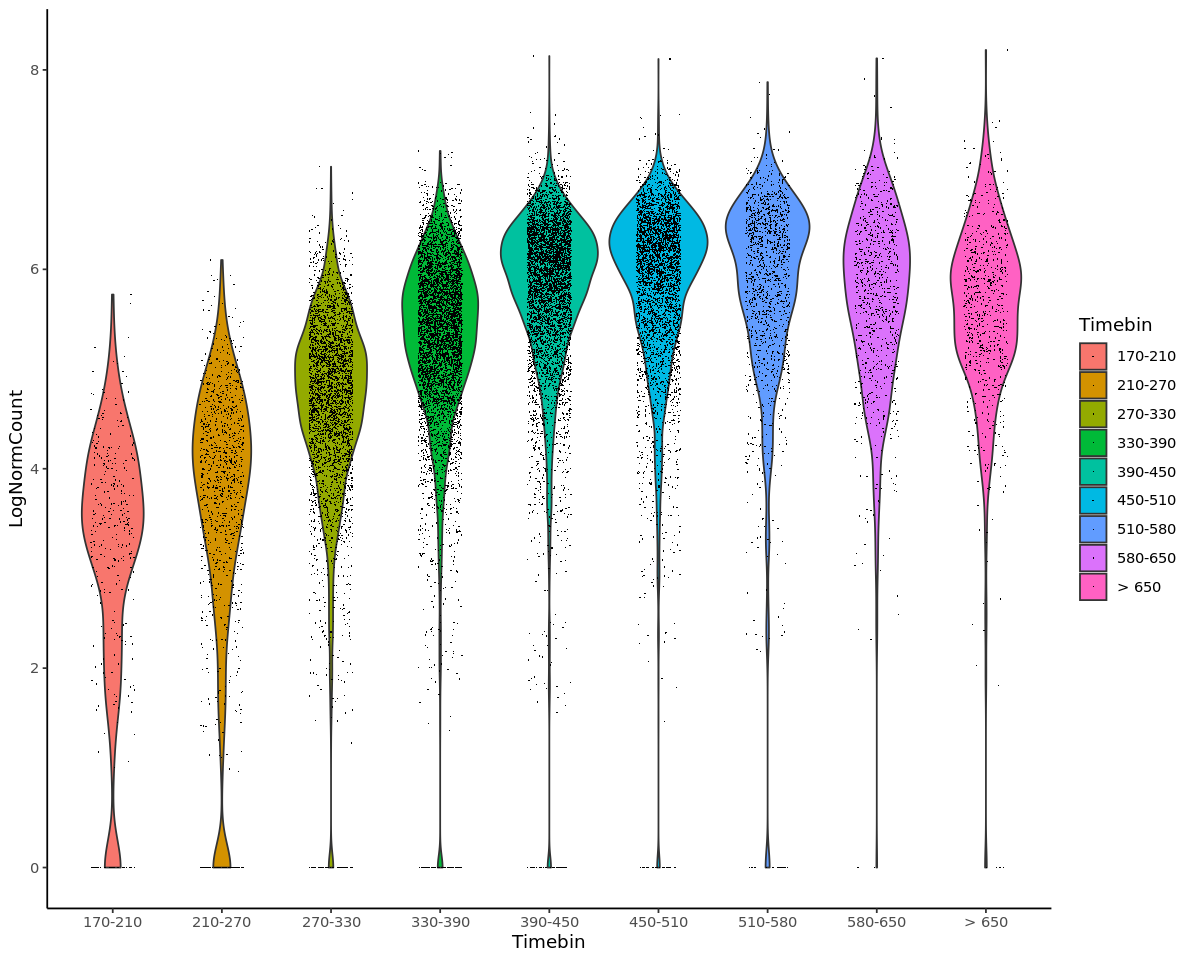

In [26]:
gene='act-4'

df.Mus <- cbind(melt(mat.whole.Mus[gene,]),timebinMus)
df.Mus <- df.Mus[,-1]
colnames(df.Mus) <- c('LogNormCount','Timebin')

# Turn timebin into a factor with the levels in the correct order
df.Mus$Timebin <- factor(df.Mus$Timebin, levels=c('170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'))

options(repr.plot.width=10, repr.plot.height=8)
ggplot(df.Mus, aes(x = Timebin, y = LogNormCount, fill = Timebin)) + geom_violin()+ geom_jitter(shape=16, position=position_jitter(0.2),size=0.08)+ theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()) 
# + geom_point(position = position_jitterdodge(seed = 1, dodge.width = 1),size=0.001)+theme_bw() 

In [58]:
genes=c('act-4','mlc-3','lev-11')

for (gene in genes){
    # Make a dataframe for this gene
    df.Mus <- cbind(melt(mat.whole.Mus[gene,]),timebinMus)
    df.Mus <- df.Mus[,-1]
    colnames(df.Mus) <- c('LogNormCount','Timebin')

    # Turn timebin into a factor with the levels in the correct order
    df.Mus$Timebin <- factor(df.Mus$Timebin, levels=c('170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'))

    # Violin plot
    plot <- ggplot(df.Mus, aes(x = Timebin, y = LogNormCount, fill = Timebin)) + geom_violin()+ geom_jitter(shape=16, position=position_jitter(0.2),size=0.08)+ theme(axis.line = element_line(colour = "black"),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank()) 
    ggsave(filename = paste("Mus_",gene,".png",sep = ""), plot, width=10, height=8, dpi = 300)
}

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



## Neuron cells

In [29]:
neu <- matList[[2]] 
matListNeu <- list()
timebinListNeu <- list()
for (i in 1:length(cell_ind_timebin)){
  mat <- neu[,which(dimnames(neu)[[2]] %in% cell_ind_timebin[[i]])]
  matListNeu[[i]] <- mat
  timebinListNeu[[i]]<-rep(names(cell_ind_timebin)[[i]],ncol(mat))
}

In [30]:
mat.whole.Neu <- do.call(cbind,matListNeu)
timebinNeu <- do.call(c,timebinListNeu)
timebinNeu <- data.frame(timebinNeu)
dim(mat.whole.Neu)[2] == nrow(timebinNeu)
colnames(timebinNeu) <- "Time bin"
mat.whole.Neu <- data.frame(as.matrix(mat.whole.Neu))
rownames(timebinNeu) <- colnames(mat.whole.Neu)

[1] TRUE

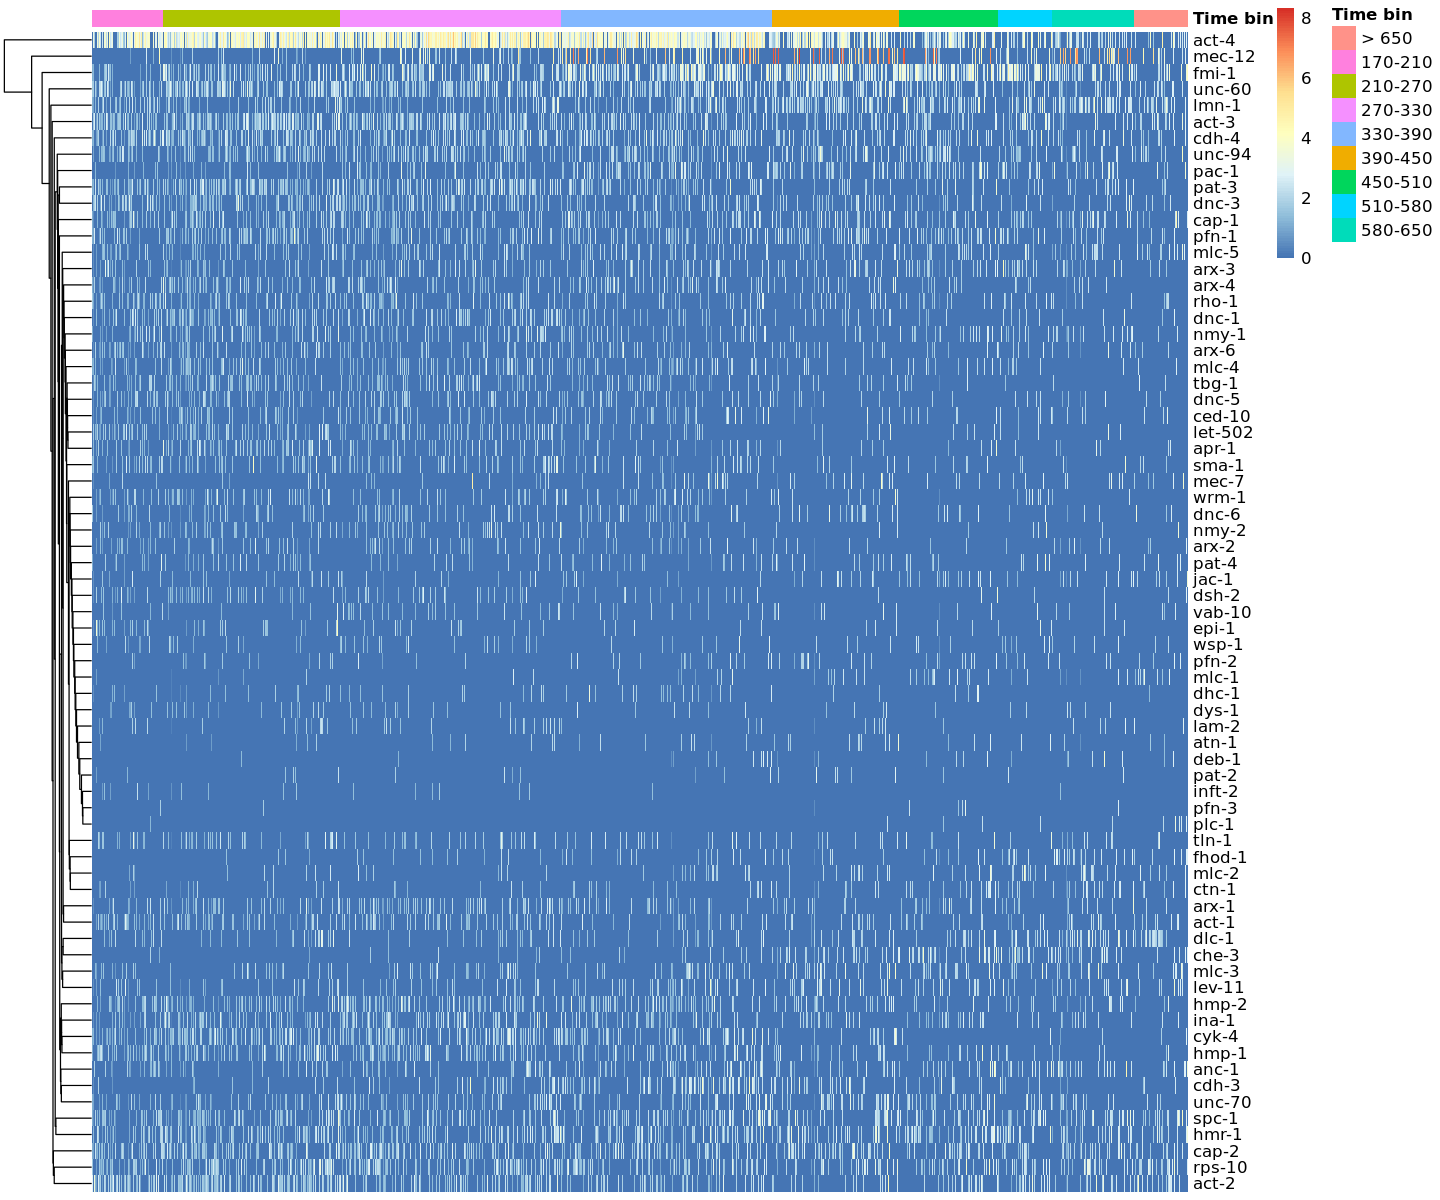

In [31]:
options(repr.plot.width=12, repr.plot.height=10)
pheatmap(mat.whole.Neu, annotation=timebinNeu, cluster_cols=FALSE, show_colnames=FALSE)

No id variables; using all as measure variables



,LogNormCount,Timebin
,<dbl>,<fct>
AAACCTGGTGTGAATA.300.1.1,0.000000,170-210
AACTCAGTCTTATCTG.300.1.1,1.542885,170-210
AAGGCAGGTGGGTATG.300.1.1,2.153812,170-210
ACACCAAAGATGTTAG.300.1.1,0.000000,170-210
ACGAGCCGTGAACCTT.300.1.1,4.026690,170-210
ACGAGGACATCCTAGA.300.1.1,2.868409,170-210


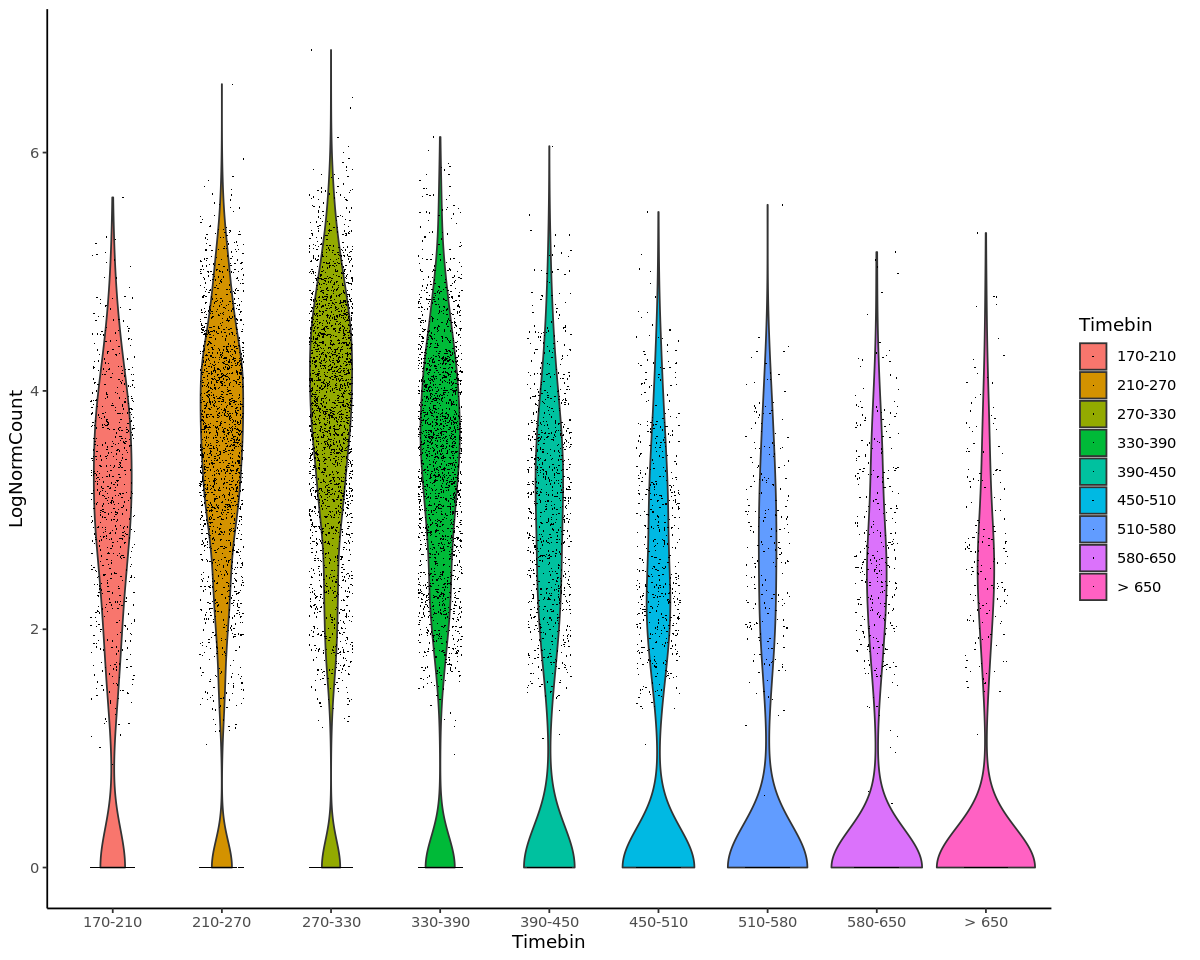

In [48]:
# Make a dataframe for this gene
gene='act-4'
df.Neu <- cbind(melt(mat.whole.Neu[gene,]),timebinNeu)
df.Neu <- df.Neu[,-1]
colnames(df.Neu) <- c('LogNormCount','Timebin')

# Turn timebin into a factor with the levels in the correct order
df.Neu$Timebin <- factor(df.Neu$Timebin, levels=c('170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'))
head(df.Neu)

# Violin plot
options(repr.plot.width=10, repr.plot.height=8)
ggplot(df.Neu, aes(x = Timebin, y = LogNormCount, fill = Timebin)) + geom_violin()+ geom_jitter(shape=16, position=position_jitter(0.2),size=0.08)+ theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()) 

In [57]:
genes=c('act-4','mlc-3','lev-11')

for (gene in genes){
    # Make a dataframe for this gene
    df.Neu <- cbind(melt(mat.whole.Neu[gene,]),timebinNeu)
    df.Neu <- df.Neu[,-1]
    colnames(df.Neu) <- c('LogNormCount','Timebin')

    # Turn timebin into a factor with the levels in the correct order
    df.Neu$Timebin <- factor(df.Neu$Timebin, levels=c('170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'))

    # Violin plot
    plot <- ggplot(df.Neu, aes(x = Timebin, y = LogNormCount, fill = Timebin)) + geom_violin()+ geom_jitter(shape=16, position=position_jitter(0.2),size=0.08)+ theme(axis.line = element_line(colour = "black"),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank()) 
    ggsave(filename = paste("Neu_",gene,".png",sep = ""), plot, width=10, height=8, dpi = 300)
}

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



## Gland cells

In [34]:
gla <- matList[[3]] 
matListGla <- list()
timebinListGla <- list()
for (i in 1:length(cell_ind_timebin)){
  mat <- gla[,which(dimnames(gla)[[2]] %in% cell_ind_timebin[[i]])]
  matListGla[[i]] <- mat
  timebinListGla[[i]]<-rep(names(cell_ind_timebin)[[i]],ncol(mat))
}

In [35]:
mat.whole.Gla <- do.call(cbind,matListGla)
timebinGla <- do.call(c,timebinListGla)
timebinGla <- data.frame(timebinGla)
dim(mat.whole.Gla)[2] == nrow(timebinGla)
colnames(timebinGla) <- "Time bin"
mat.whole.Gla <- data.frame(as.matrix(mat.whole.Gla))
rownames(timebinGla) <- colnames(mat.whole.Gla)

[1] TRUE

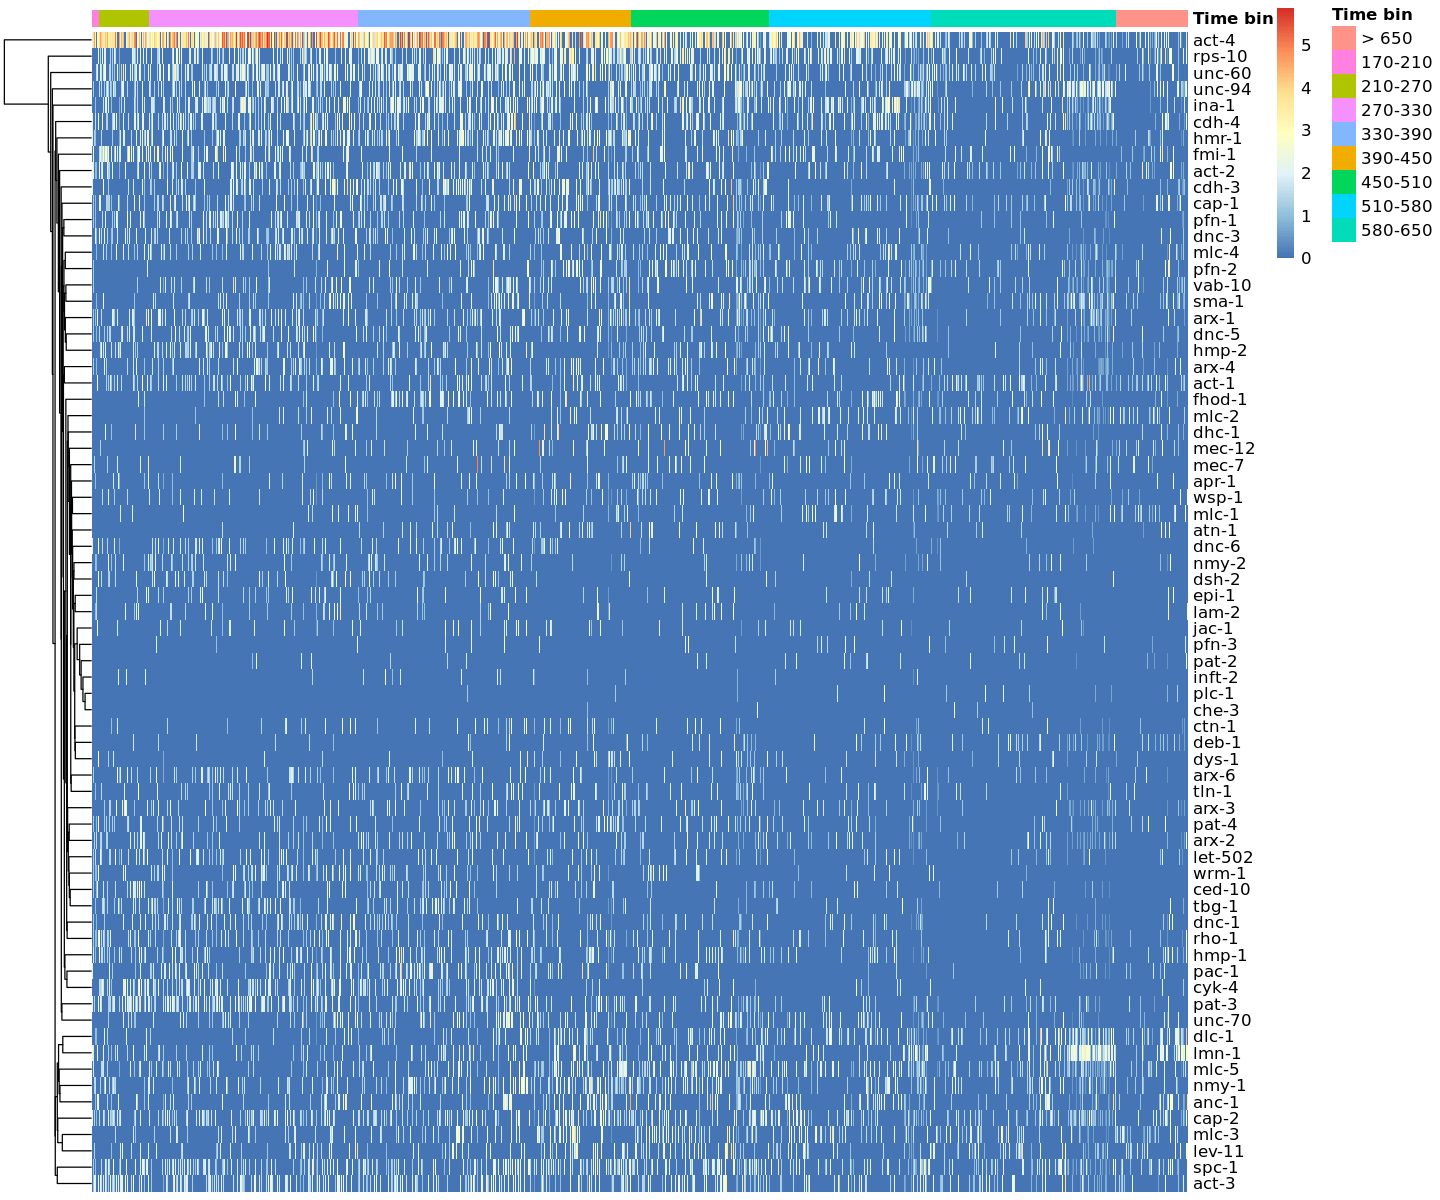

In [36]:
options(repr.plot.width=12, repr.plot.height=10)
pheatmap(mat.whole.Gla, annotation=timebinGla, cluster_cols=FALSE, show_colnames=FALSE)

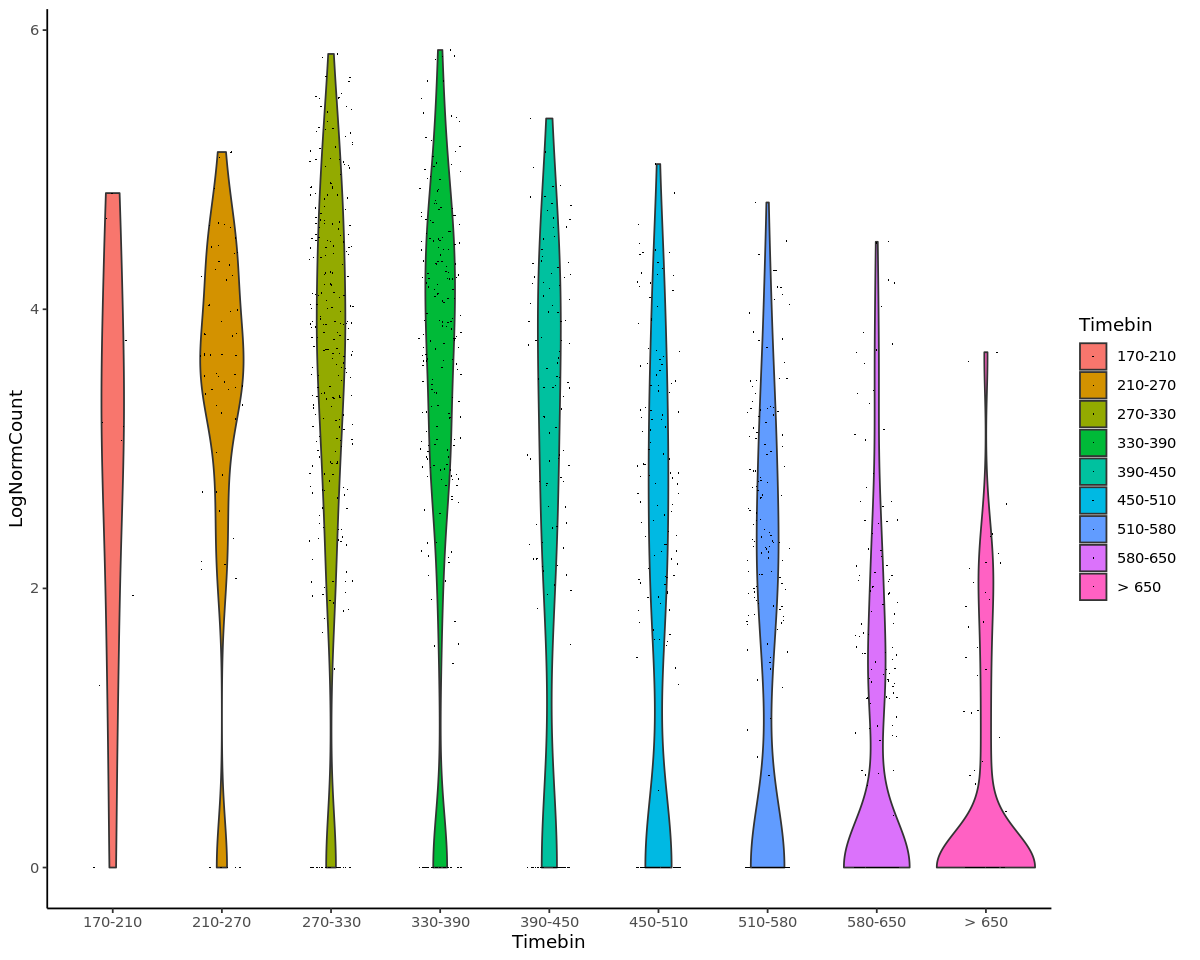

In [38]:
# Make a dataframe for this gene
gene='act-4'
df.Gla <- cbind(melt(mat.whole.Gla[gene,]),timebinGla)
df.Gla <- df.Gla[,-1]
colnames(df.Gla) <- c('LogNormCount','Timebin')

# Turn timebin into a factor with the levels in the correct order
df.Gla$Timebin <- factor(df.Gla$Timebin, levels=c('170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'))
head(df.Gla)

# Violin plot
options(repr.plot.width=10, repr.plot.height=8)
ggplot(df.Gla, aes(x = Timebin, y = LogNormCount, fill = Timebin)) + geom_violin()+ geom_jitter(shape=16, position=position_jitter(0.2),size=0.08)+ theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()) 

In [59]:
genes=c('act-4','mlc-3','lev-11')

for (gene in genes){
    # Make a dataframe for this gene
    df.Gla <- cbind(melt(mat.whole.Gla[gene,]),timebinGla)
    df.Gla <- df.Gla[,-1]
    colnames(df.Gla) <- c('LogNormCount','Timebin')

    # Turn timebin into a factor with the levels in the correct order
    df.Gla$Timebin <- factor(df.Gla$Timebin, levels=c('170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'))

    # Violin plot
    plot <- ggplot(df.Gla, aes(x = Timebin, y = LogNormCount, fill = Timebin)) + geom_violin()+ geom_jitter(shape=16, position=position_jitter(0.2),size=0.08)+ theme(axis.line = element_line(colour = "black"),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank()) 
    ggsave(filename = paste("Gla_",gene,".png",sep = ""), plot, width=10, height=8, dpi = 300)
}

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables



## Hypodermis

In [39]:
hyp <- matList[[4]] 
matListHyp <- list()
timebinListHyp <- list()
for (i in 1:length(cell_ind_timebin)){
  mat <- hyp[,which(dimnames(hyp)[[2]] %in% cell_ind_timebin[[i]])]
  matListHyp[[i]] <- mat
  timebinListHyp[[i]]<-rep(names(cell_ind_timebin)[[i]],ncol(mat))
}

In [40]:
mat.whole.Hyp <- do.call(cbind,matListHyp)
timebinHyp <- do.call(c,timebinListHyp)
timebinHyp <- data.frame(timebinHyp)
dim(mat.whole.Hyp)[2] == nrow(timebinHyp)
colnames(timebinHyp) <- "Time bin"
mat.whole.Hyp <- data.frame(as.matrix(mat.whole.Hyp))
rownames(timebinHyp) <- colnames(mat.whole.Hyp)

[1] TRUE

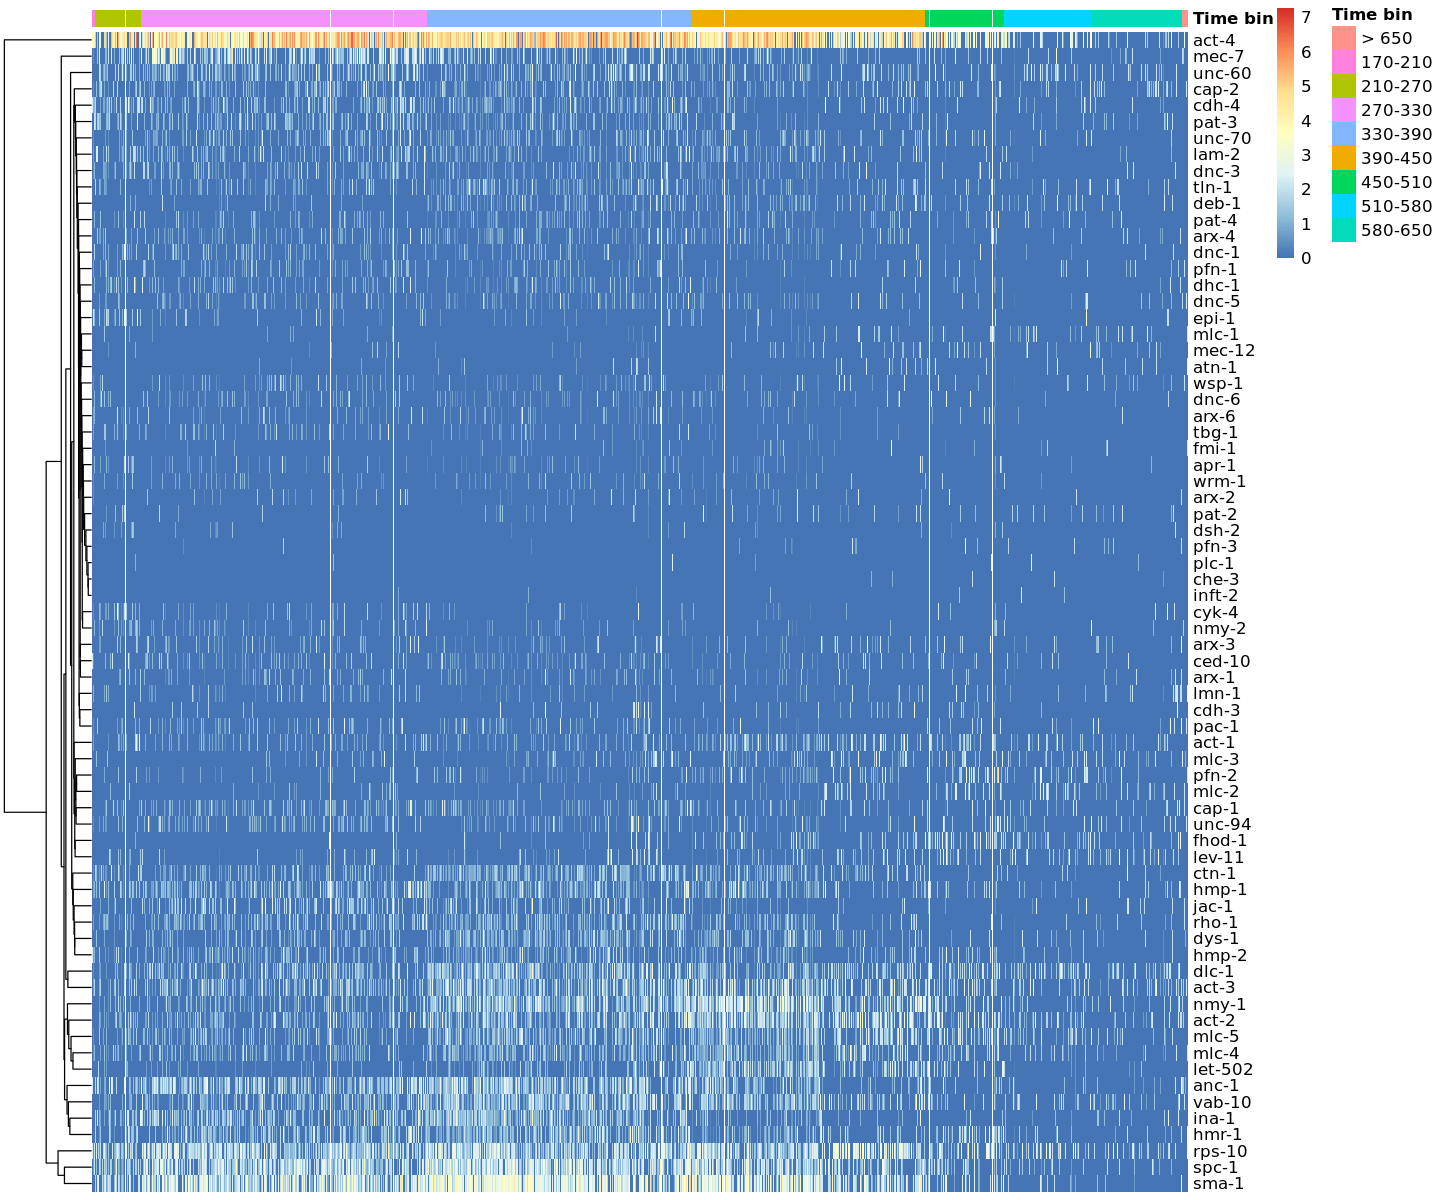

In [41]:
options(repr.plot.width=12, repr.plot.height=10)
pheatmap(mat.whole.Hyp, annotation=timebinHyp, cluster_cols=FALSE, show_colnames=FALSE)

In [42]:
# Make a dataframe for this gene
gene='act-4'
df.Hyp <- cbind(melt(mat.whole.Hyp[gene,]),timebinHyp)
df.Hyp <- df.Hyp[,-1]
colnames(df.Hyp) <- c('LogNormCount','Timebin')

# Turn timebin into a factor with the levels in the correct order
df.Hyp$Timebin <- factor(df.Hyp$Timebin, levels=c('170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'))
head(df.Hyp)

No id variables; using all as measure variables



,LogNormCount,Timebin
,<dbl>,<fct>
GTACGTAAGCGGATCA.300.1.1,3.301636,170-210
CGGTTAAGTGGCTCCA.300.1.2,2.947191,170-210
ATGCGATAGAATAGGG.300.1.3,0.000000,170-210
CTCGGGAGTTGTCTTT.300.1.3,1.803755,170-210
CTCATTACAAGTTGTC.400.2.1,0.000000,170-210
TGTATTCCAATGAAAC.400.2.1,3.673719,170-210


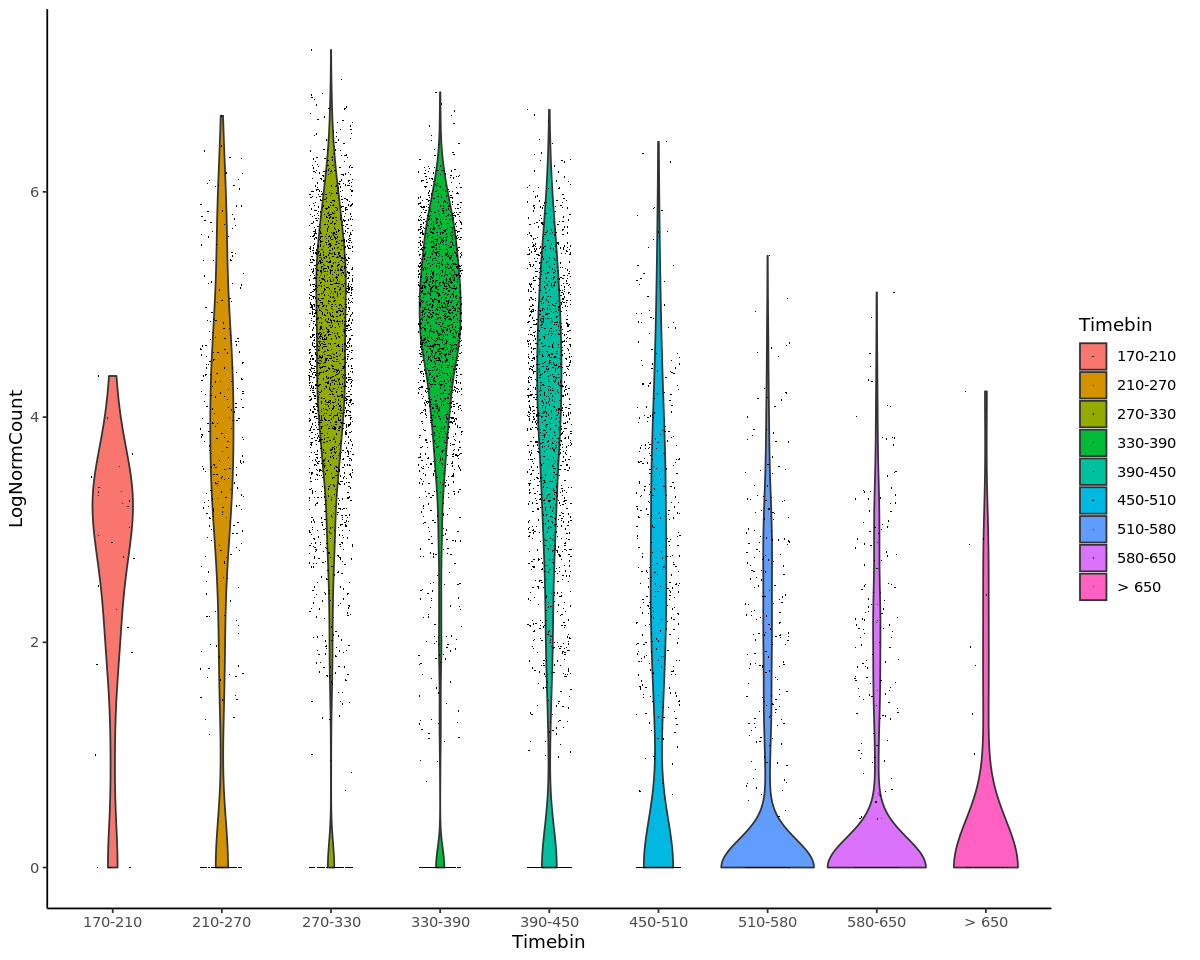

In [43]:
# Violin plot
options(repr.plot.width=10, repr.plot.height=8)
ggplot(df.Hyp, aes(x = Timebin, y = LogNormCount, fill = Timebin)) + geom_violin()+ geom_jitter(shape=16, position=position_jitter(0.2),size=0.08)+ theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()) 

In [60]:
genes=c('act-4','mlc-3','lev-11')

for (gene in genes){
    # Make a dataframe for this gene
    df.Hyp <- cbind(melt(mat.whole.Hyp[gene,]),timebinHyp)
    df.Hyp <- df.Hyp[,-1]
    colnames(df.Hyp) <- c('LogNormCount','Timebin')

    # Turn timebin into a factor with the levels in the correct order
    df.Hyp$Timebin <- factor(df.Hyp$Timebin, levels=c('170-210','210-270','270-330','330-390','390-450','450-510','510-580','580-650','> 650'))

    # Violin plot
    plot <- ggplot(df.Hyp, aes(x = Timebin, y = LogNormCount, fill = Timebin)) + geom_violin()+ geom_jitter(shape=16, position=position_jitter(0.2),size=0.08)+ theme(axis.line = element_line(colour = "black"),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank()) 
    ggsave(filename = paste("Hyp_",gene,".png",sep = ""), plot, width=10, height=8, dpi = 300)
}

No id variables; using all as measure variables

No id variables; using all as measure variables

No id variables; using all as measure variables

